Using device: cuda
Episode 0, Reward: -200.00, Epsilon: 0.995
Episode 1, Reward: -200.00, Epsilon: 0.990
Episode 2, Reward: -200.00, Epsilon: 0.985
Episode 3, Reward: -200.00, Epsilon: 0.980
Episode 4, Reward: -200.00, Epsilon: 0.975
Episode 5, Reward: -200.00, Epsilon: 0.970
Episode 6, Reward: -200.00, Epsilon: 0.966
Episode 7, Reward: -200.00, Epsilon: 0.961
Episode 8, Reward: -200.00, Epsilon: 0.956
Episode 9, Reward: -200.00, Epsilon: 0.951
Episode 10, Reward: -200.00, Epsilon: 0.946
Episode 11, Reward: -200.00, Epsilon: 0.942
Episode 12, Reward: -200.00, Epsilon: 0.937
Episode 13, Reward: -200.00, Epsilon: 0.932
Episode 14, Reward: -200.00, Epsilon: 0.928
Episode 15, Reward: -200.00, Epsilon: 0.923
Episode 16, Reward: -200.00, Epsilon: 0.918
Episode 17, Reward: -200.00, Epsilon: 0.914
Episode 18, Reward: -200.00, Epsilon: 0.909
Episode 19, Reward: -200.00, Epsilon: 0.905
Episode 20, Reward: -200.00, Epsilon: 0.900
Episode 21, Reward: -200.00, Epsilon: 0.896
Episode 22, Reward: -20

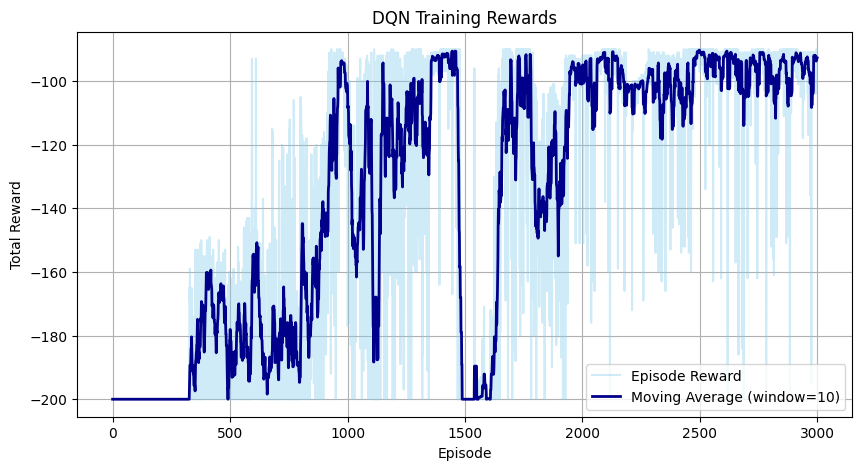

In [ ]:
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)


class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size=64):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (
            torch.tensor(state, dtype=torch.float32).to(device),
            torch.tensor(action).to(device),
            torch.tensor(reward).to(device),
            torch.tensor(next_state, dtype=torch.float32).to(device),
            torch.tensor(done, dtype=torch.float32).to(device)
        )

    def __len__(self):
        return len(self.buffer)


def select_action(state, policy_net, epsilon, action_space):
    if random.random() < epsilon:
        return action_space.sample()
    else:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            q_values = policy_net(state_tensor)
            return q_values.argmax().item()



def train_dqn(
    env,
    episodes=3000,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995,
    learning_rate=1e-3,
    target_update=10,
    batch_size=128
):
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    policy_net = DQN(obs_dim, n_actions).to(device)
    target_net = DQN(obs_dim, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    replay_buffer = ReplayBuffer()

    epsilon = epsilon_start
    rewards_per_episode = []

    for episode in range(episodes):
        state, _ = env.reset(seed=SEED)
        total_reward = 0

        while True:
            action = select_action(state, policy_net, epsilon, env.action_space)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward


            if len(replay_buffer) >= batch_size:
                s_batch, a_batch, r_batch, ns_batch, d_batch = replay_buffer.sample(batch_size)

                q_values = policy_net(s_batch).gather(1, a_batch.unsqueeze(1)).squeeze(1)
                next_q_values = target_net(ns_batch).max(1)[0]
                target_q = r_batch + gamma * next_q_values * (1 - d_batch)

                loss = nn.MSELoss()(q_values, target_q.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break


        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)


        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        print(f"Episode {episode}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")

    return rewards_per_episode


def plot_rewards(rewards, window_size=10):
    mean_rewards = plot_rewards_mean(rewards, window_size)

    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Episode Reward", color="skyblue", alpha=0.4)
    plt.plot(mean_rewards, label=f"Moving Average (window={window_size})", color="darkblue", linewidth=2)
    plt.title("DQN Training Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True)
    plt.savefig("dqn_mountaincar_rewards.png")
    plt.show()

def plot_rewards_mean(rewards, d):
    m = []
    for i in range(len(rewards)):
        if i < d:
            m.append(np.mean(rewards[:i+1]))
        else:
            m.append(np.mean(rewards[i-d+1:i+1]))
    return m



if __name__ == "__main__":
    env = gym.make("MountainCar-v0")
    env.action_space.seed(SEED)
    rewards = train_dqn(env)
    plot_rewards(rewards, window_size=10)
    env.close()

Using device: cpu

--- Learning Rate = 0.0001 ---


/tmp/ipython-input-1127574913.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  torch.tensor(state, dtype=torch.float32).to(device),


Episode 0, Reward: -200.00, Epsilon: 0.995
Episode 1, Reward: -200.00, Epsilon: 0.990
Episode 2, Reward: -200.00, Epsilon: 0.985
Episode 3, Reward: -200.00, Epsilon: 0.980
Episode 4, Reward: -200.00, Epsilon: 0.975
Episode 5, Reward: -200.00, Epsilon: 0.970
Episode 6, Reward: -200.00, Epsilon: 0.966
Episode 7, Reward: -200.00, Epsilon: 0.961
Episode 8, Reward: -200.00, Epsilon: 0.956
Episode 9, Reward: -200.00, Epsilon: 0.951
Episode 10, Reward: -200.00, Epsilon: 0.946
Episode 11, Reward: -200.00, Epsilon: 0.942
Episode 12, Reward: -200.00, Epsilon: 0.937
Episode 13, Reward: -200.00, Epsilon: 0.932
Episode 14, Reward: -200.00, Epsilon: 0.928
Episode 15, Reward: -200.00, Epsilon: 0.923
Episode 16, Reward: -200.00, Epsilon: 0.918
Episode 17, Reward: -200.00, Epsilon: 0.914
Episode 18, Reward: -200.00, Epsilon: 0.909
Episode 19, Reward: -200.00, Epsilon: 0.905
Episode 20, Reward: -200.00, Epsilon: 0.900
Episode 21, Reward: -200.00, Epsilon: 0.896
Episode 22, Reward: -200.00, Epsilon: 0.89

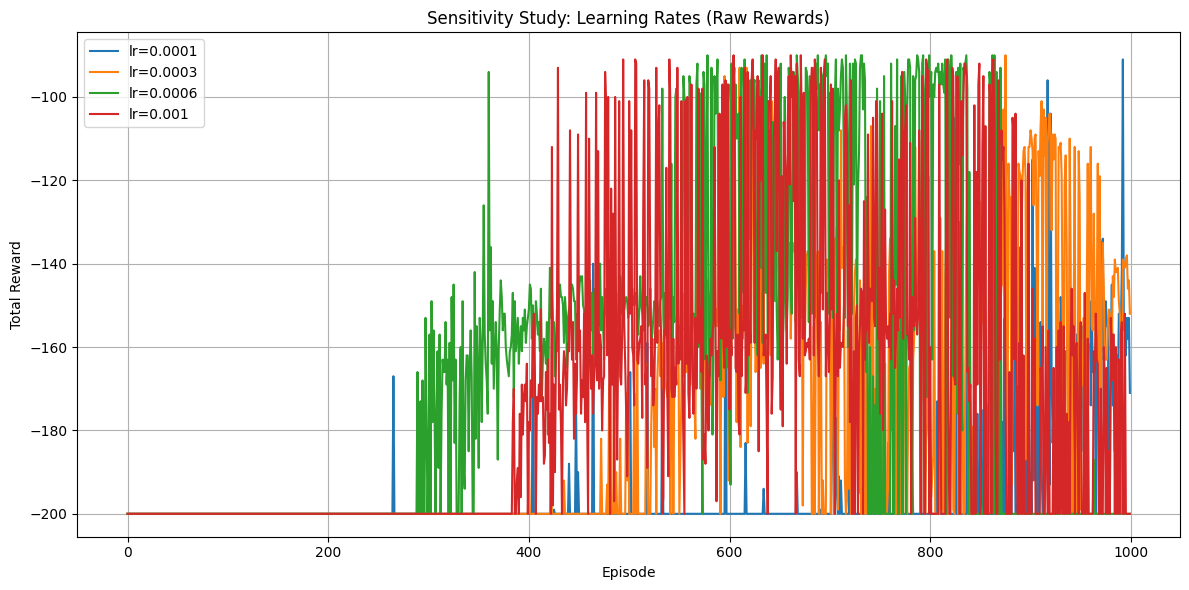

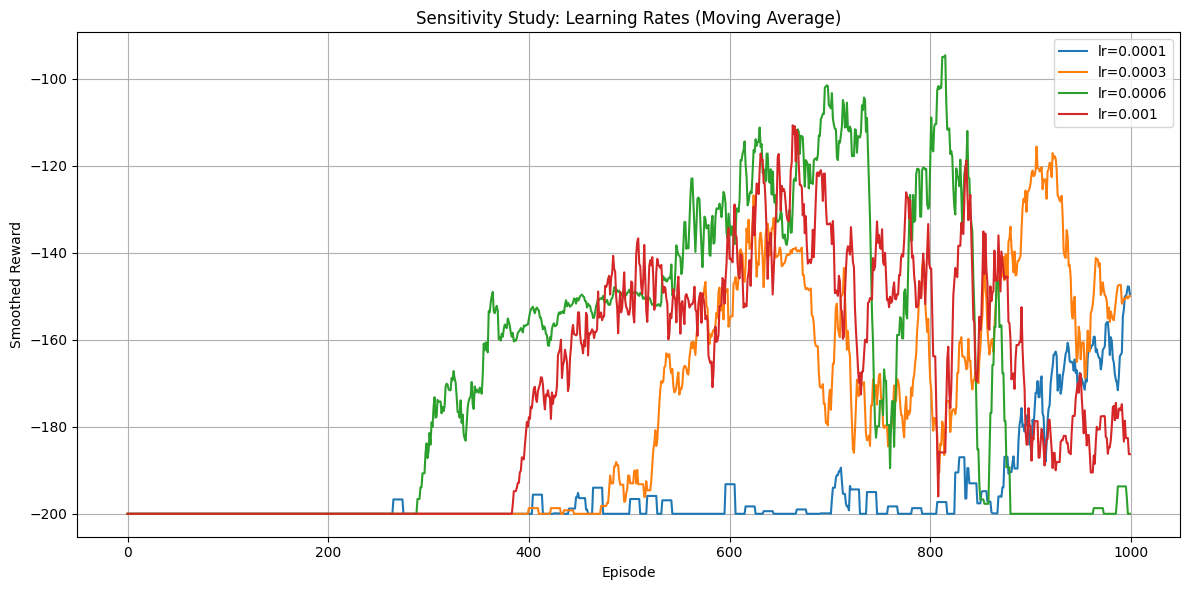


--- Gamma = 0.9 ---
Episode 0, Reward: -200.00, Epsilon: 0.995
Episode 1, Reward: -200.00, Epsilon: 0.990
Episode 2, Reward: -200.00, Epsilon: 0.985
Episode 3, Reward: -200.00, Epsilon: 0.980
Episode 4, Reward: -200.00, Epsilon: 0.975
Episode 5, Reward: -200.00, Epsilon: 0.970
Episode 6, Reward: -200.00, Epsilon: 0.966
Episode 7, Reward: -200.00, Epsilon: 0.961
Episode 8, Reward: -200.00, Epsilon: 0.956
Episode 9, Reward: -200.00, Epsilon: 0.951
Episode 10, Reward: -200.00, Epsilon: 0.946
Episode 11, Reward: -200.00, Epsilon: 0.942
Episode 12, Reward: -200.00, Epsilon: 0.937
Episode 13, Reward: -200.00, Epsilon: 0.932
Episode 14, Reward: -200.00, Epsilon: 0.928
Episode 15, Reward: -200.00, Epsilon: 0.923
Episode 16, Reward: -200.00, Epsilon: 0.918
Episode 17, Reward: -200.00, Epsilon: 0.914
Episode 18, Reward: -200.00, Epsilon: 0.909
Episode 19, Reward: -200.00, Epsilon: 0.905
Episode 20, Reward: -200.00, Epsilon: 0.900
Episode 21, Reward: -200.00, Epsilon: 0.896
Episode 22, Reward: -

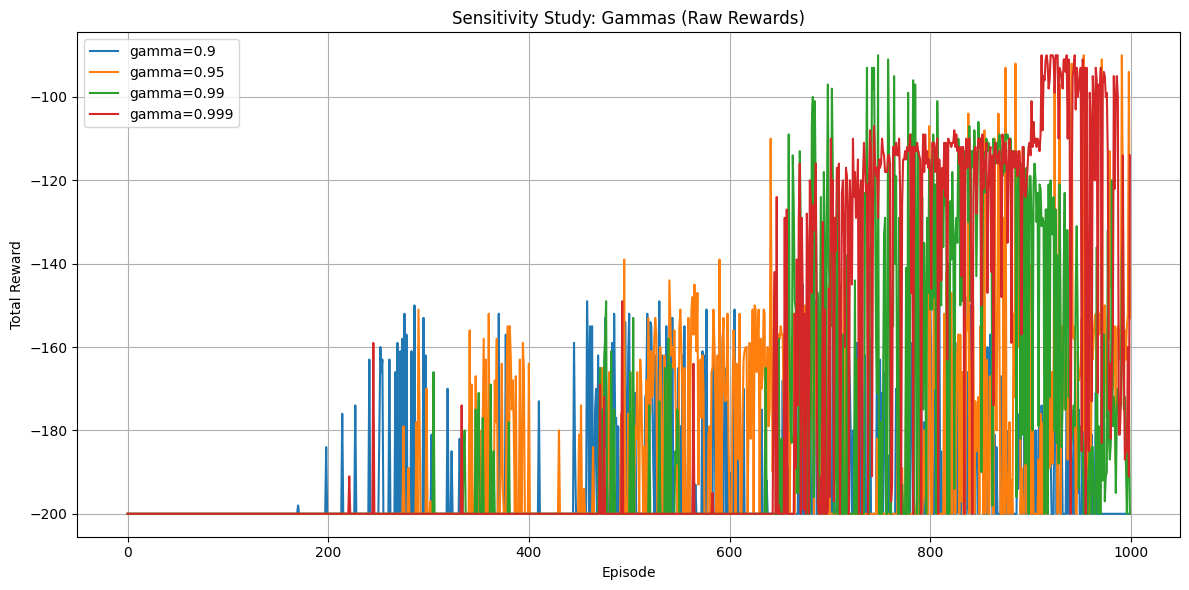

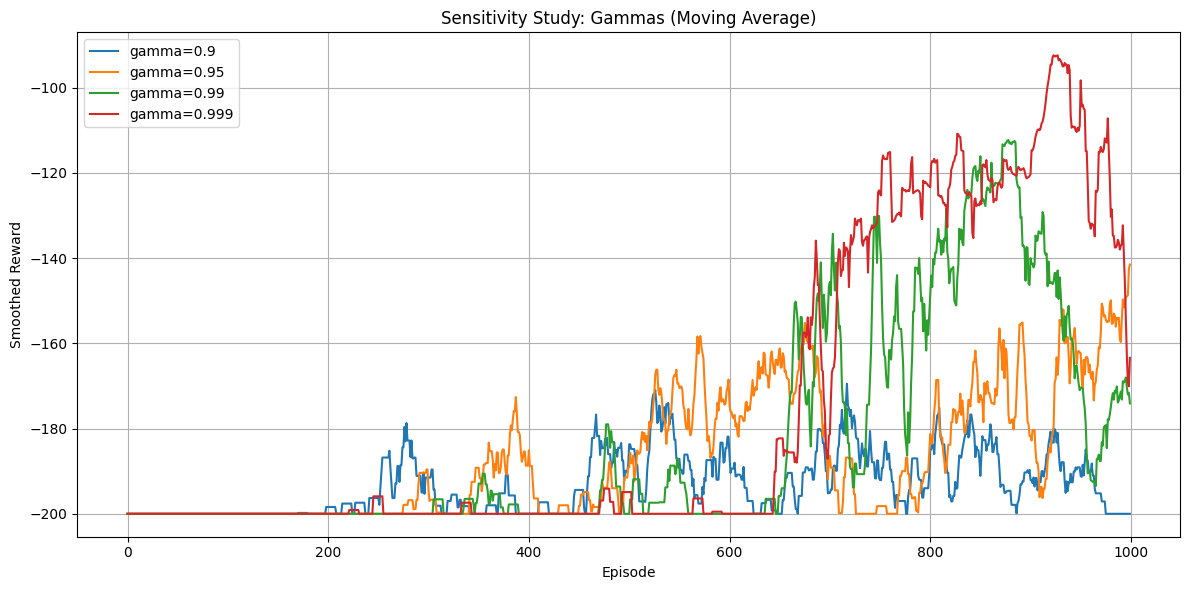


--- Batch Size = 32 ---
Episode 0, Reward: -200.00, Epsilon: 0.995
Episode 1, Reward: -200.00, Epsilon: 0.990
Episode 2, Reward: -200.00, Epsilon: 0.985
Episode 3, Reward: -200.00, Epsilon: 0.980
Episode 4, Reward: -200.00, Epsilon: 0.975
Episode 5, Reward: -200.00, Epsilon: 0.970
Episode 6, Reward: -200.00, Epsilon: 0.966
Episode 7, Reward: -200.00, Epsilon: 0.961
Episode 8, Reward: -200.00, Epsilon: 0.956
Episode 9, Reward: -200.00, Epsilon: 0.951
Episode 10, Reward: -200.00, Epsilon: 0.946
Episode 11, Reward: -200.00, Epsilon: 0.942
Episode 12, Reward: -200.00, Epsilon: 0.937
Episode 13, Reward: -200.00, Epsilon: 0.932
Episode 14, Reward: -200.00, Epsilon: 0.928
Episode 15, Reward: -200.00, Epsilon: 0.923
Episode 16, Reward: -200.00, Epsilon: 0.918
Episode 17, Reward: -200.00, Epsilon: 0.914
Episode 18, Reward: -200.00, Epsilon: 0.909
Episode 19, Reward: -200.00, Epsilon: 0.905
Episode 20, Reward: -200.00, Epsilon: 0.900
Episode 21, Reward: -200.00, Epsilon: 0.896
Episode 22, Rewar

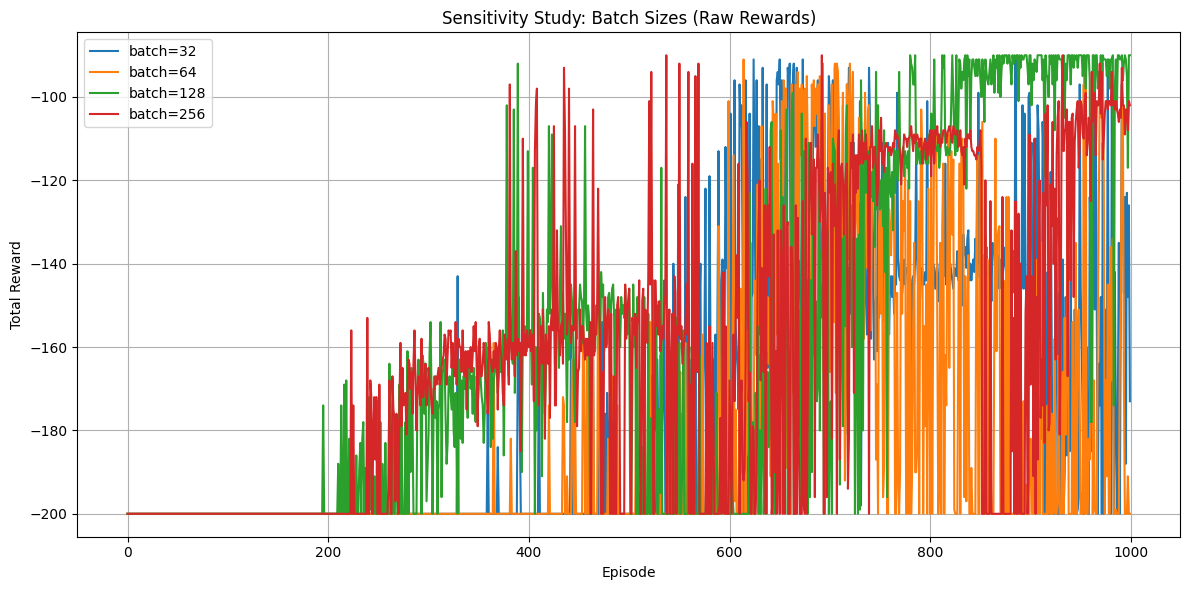

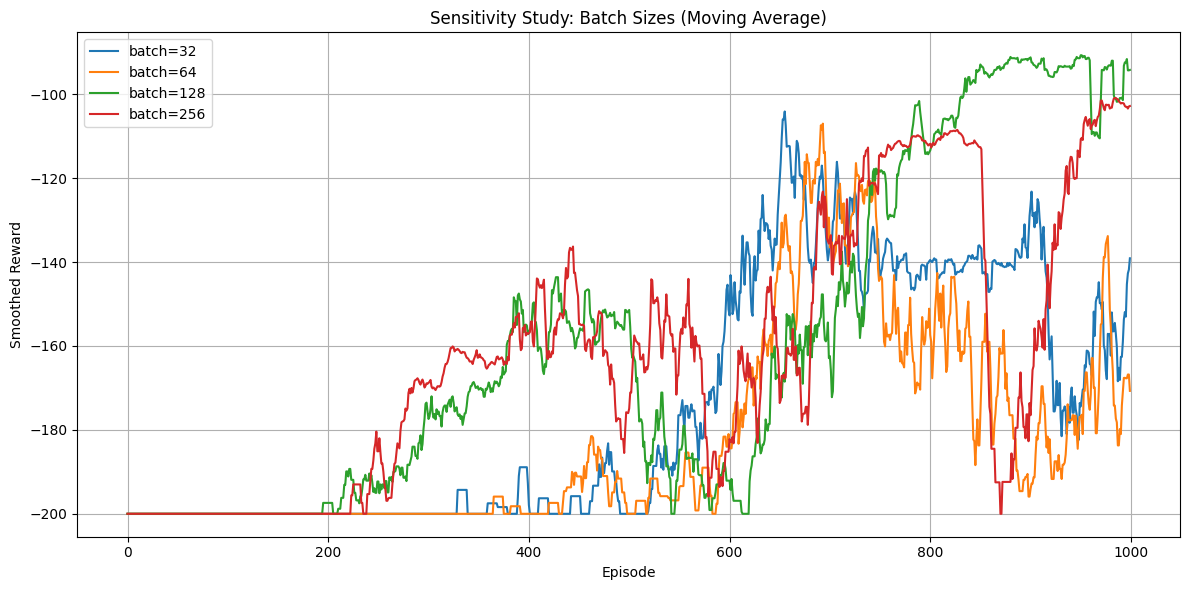


--- Epsilon Decay = 0.98 ---
Episode 0, Reward: -200.00, Epsilon: 0.980
Episode 1, Reward: -200.00, Epsilon: 0.960
Episode 2, Reward: -200.00, Epsilon: 0.941
Episode 3, Reward: -200.00, Epsilon: 0.922
Episode 4, Reward: -200.00, Epsilon: 0.904
Episode 5, Reward: -200.00, Epsilon: 0.886
Episode 6, Reward: -200.00, Epsilon: 0.868
Episode 7, Reward: -200.00, Epsilon: 0.851
Episode 8, Reward: -200.00, Epsilon: 0.834
Episode 9, Reward: -200.00, Epsilon: 0.817
Episode 10, Reward: -200.00, Epsilon: 0.801
Episode 11, Reward: -200.00, Epsilon: 0.785
Episode 12, Reward: -200.00, Epsilon: 0.769
Episode 13, Reward: -200.00, Epsilon: 0.754
Episode 14, Reward: -200.00, Epsilon: 0.739
Episode 15, Reward: -200.00, Epsilon: 0.724
Episode 16, Reward: -200.00, Epsilon: 0.709
Episode 17, Reward: -200.00, Epsilon: 0.695
Episode 18, Reward: -200.00, Epsilon: 0.681
Episode 19, Reward: -200.00, Epsilon: 0.668
Episode 20, Reward: -200.00, Epsilon: 0.654
Episode 21, Reward: -200.00, Epsilon: 0.641
Episode 22, 

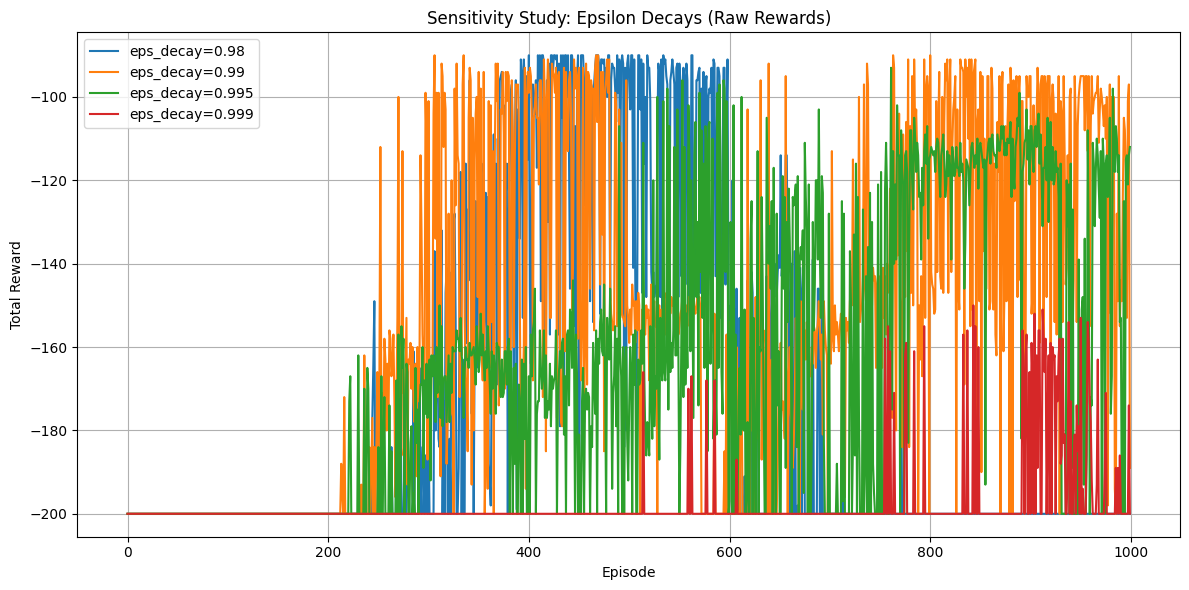

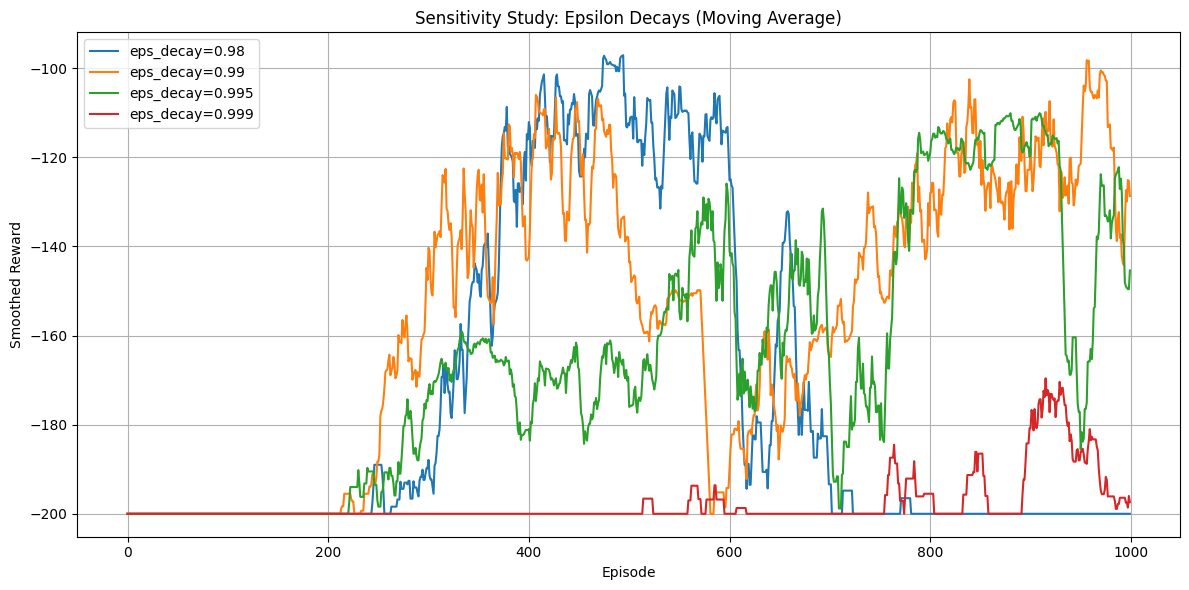

In [ ]:
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#Neural Network
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size=64):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (
            torch.tensor(state, dtype=torch.float32).to(device),
            torch.tensor(action).to(device),
            torch.tensor(reward).to(device),
            torch.tensor(next_state, dtype=torch.float32).to(device),
            torch.tensor(done, dtype=torch.float32).to(device)
        )

    def __len__(self):
        return len(self.buffer)

# policy
def select_action(state, policy_net, epsilon, action_space):
    if random.random() < epsilon:
        return action_space.sample()
    else:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            q_values = policy_net(state_tensor)
            return q_values.argmax().item()

# Training Loop
def train_dqn(
    env,
    episodes=1000,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995,
    learning_rate=0.001,
    target_update=10,
    batch_size=64
):
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    policy_net = DQN(obs_dim, n_actions).to(device)
    target_net = DQN(obs_dim, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    replay_buffer = ReplayBuffer()

    epsilon = epsilon_start
    rewards_per_episode = []

    for episode in range(episodes):
        state, _ = env.reset(seed=SEED)
        total_reward = 0

        while True:
            action = select_action(state, policy_net, epsilon, env.action_space)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            #Train only if buffer has enough samples
            if len(replay_buffer) >= batch_size:
                s_batch, a_batch, r_batch, ns_batch, d_batch = replay_buffer.sample(batch_size)

                q_values = policy_net(s_batch).gather(1, a_batch.unsqueeze(1)).squeeze(1)
                next_q_values = target_net(ns_batch).max(1)[0]
                target_q = r_batch + gamma * next_q_values * (1 - d_batch)

                loss = nn.MSELoss()(q_values, target_q.detach())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        #Decay epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)


        rewards_per_episode.append(total_reward)

        # Update target network
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        print(f"Episode {episode}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")

    return rewards_per_episode




def plot_rewards_mean(rewards, d):
    m = []
    for i in range(len(rewards)):
        if i < d:
            m.append(np.mean(rewards[:i+1]))
        else:
            m.append(np.mean(rewards[i-d+1:i+1]))
    return m


def plot_rewards(results_dict, title, avg_window=10):
    #Plot 1: Raw rewards
    plt.figure(figsize=(12, 6))
    for label, rewards in results_dict.items():
        plt.plot(rewards, label=label)
    plt.title(f"{title} (Raw Rewards)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_').lower()}_raw.png")
    plt.show()

    #Plot 2: Moving Average only
    plt.figure(figsize=(12, 6))
    for label, rewards in results_dict.items():
        smooth = plot_rewards_mean(rewards, avg_window)
        plt.plot(smooth, label=label)
    plt.title(f"{title} (Moving Average)")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_').lower()}_avg.png")
    plt.show()

if __name__ == "__main__":
    env = gym.make("MountainCar-v0")
    env.action_space.seed(SEED)


    base_lr = 0.001
    base_gamma = 0.99
    base_batch_size = 128
    base_epsilon_decay = 0.995

    #Learning Rates
    learning_rates = [0.0001, 0.0003, 0.0006, 0.001]
    lr_results = {}
    for lr in learning_rates:
        print(f"\n--- Learning Rate = {lr} ---")
        rewards = train_dqn(env, learning_rate=lr, gamma=base_gamma,
                            batch_size=base_batch_size, epsilon_decay=base_epsilon_decay)
        lr_results[f"lr={lr}"] = rewards
    plot_rewards(lr_results, "Sensitivity Study: Learning Rates")

    #Gammas
    gammas = [0.9, 0.95, 0.99, 0.999]
    gamma_results = {}
    for g in gammas:
        print(f"\n--- Gamma = {g} ---")
        rewards = train_dqn(env, learning_rate=base_lr, gamma=g,
                            batch_size=base_batch_size, epsilon_decay=base_epsilon_decay)
        gamma_results[f"gamma={g}"] = rewards
    plot_rewards(gamma_results, "Sensitivity Study: Gammas")

    # Batch Sizes
    batch_sizes = [32, 64, 128, 256]
    batch_results = {}
    for b in batch_sizes:
        print(f"\n--- Batch Size = {b} ---")
        rewards = train_dqn(env, learning_rate=base_lr, gamma=base_gamma,
                            batch_size=b, epsilon_decay=base_epsilon_decay)
        batch_results[f"batch={b}"] = rewards
    plot_rewards(batch_results, "Sensitivity Study: Batch Sizes")

   #Epsilon Decays
    epsilon_decays = [0.98, 0.99, 0.995, 0.999]
    eps_results = {}
    for e in epsilon_decays:
        print(f"\n--- Epsilon Decay = {e} ---")
        rewards = train_dqn(env, learning_rate=base_lr, gamma=base_gamma,
                            batch_size=base_batch_size, epsilon_decay=e)
        eps_results[f"eps_decay={e}"] = rewards
    plot_rewards(eps_results, "Sensitivity Study: Epsilon Decays")

    env.close()

Using device: cuda


/tmp/ipython-input-824675935.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  torch.tensor(state, dtype=torch.float32).to(device),


Episode 0, Reward: -200.00, Epsilon: 0.995
Episode 1, Reward: -200.00, Epsilon: 0.990
Episode 2, Reward: -200.00, Epsilon: 0.985
Episode 3, Reward: -200.00, Epsilon: 0.980
Episode 4, Reward: -200.00, Epsilon: 0.975
Episode 5, Reward: -200.00, Epsilon: 0.970
Episode 6, Reward: -200.00, Epsilon: 0.966
Episode 7, Reward: -200.00, Epsilon: 0.961
Episode 8, Reward: -200.00, Epsilon: 0.956
Episode 9, Reward: -200.00, Epsilon: 0.951
Episode 10, Reward: -200.00, Epsilon: 0.946
Episode 11, Reward: -200.00, Epsilon: 0.942
Episode 12, Reward: -200.00, Epsilon: 0.937
Episode 13, Reward: -200.00, Epsilon: 0.932
Episode 14, Reward: -200.00, Epsilon: 0.928
Episode 15, Reward: -200.00, Epsilon: 0.923
Episode 16, Reward: -200.00, Epsilon: 0.918
Episode 17, Reward: -200.00, Epsilon: 0.914
Episode 18, Reward: -200.00, Epsilon: 0.909
Episode 19, Reward: -200.00, Epsilon: 0.905
Episode 20, Reward: -200.00, Epsilon: 0.900
Episode 21, Reward: -200.00, Epsilon: 0.896
Episode 22, Reward: -200.00, Epsilon: 0.89

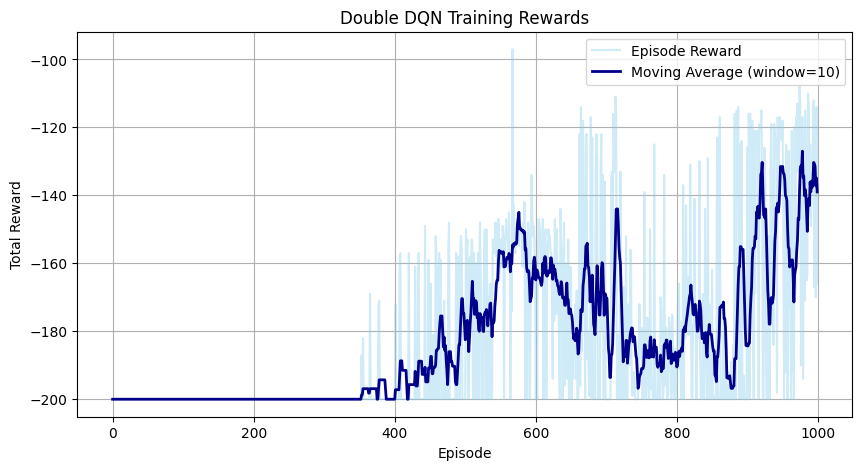

In [ ]:
#Double DQN

import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Neural Network
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)


class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size=64):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (
            torch.tensor(state, dtype=torch.float32).to(device),
            torch.tensor(action).to(device),
            torch.tensor(reward).to(device),
            torch.tensor(next_state, dtype=torch.float32).to(device),
            torch.tensor(done, dtype=torch.float32).to(device)
        )

    def __len__(self):
        return len(self.buffer)

# Policy
def select_action(state, policy_net, epsilon, action_space):
    if random.random() < epsilon:
        return action_space.sample()
    else:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            q_values = policy_net(state_tensor)
            return q_values.argmax().item()

# Training Loop
def train_dqn(
    env,
    episodes=1000,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995,
    learning_rate=1e-3,
    target_update=10,
    batch_size=128
):
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    policy_net = DQN(obs_dim, n_actions).to(device)
    target_net = DQN(obs_dim, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    replay_buffer = ReplayBuffer()

    epsilon = epsilon_start
    rewards_per_episode = []

    for episode in range(episodes):
        state, _ = env.reset(seed=SEED)
        total_reward = 0

        while True:
            action = select_action(state, policy_net, epsilon, env.action_space)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(replay_buffer) >= batch_size:
                s_batch, a_batch, r_batch, ns_batch, d_batch = replay_buffer.sample(batch_size)

                #Q(s,a) από policy_net
                q_values = policy_net(s_batch).gather(1, a_batch.unsqueeze(1)).squeeze(1)

                #Double DQN target
                with torch.no_grad():
                    next_actions = policy_net(ns_batch).argmax(1)
                    next_q_values = target_net(ns_batch).gather(
                        1, next_actions.unsqueeze(1)
                    ).squeeze(1)

                target_q = r_batch + gamma * next_q_values * (1 - d_batch)

                loss = nn.MSELoss()(q_values, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)

        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        print(f"Episode {episode}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")

    return rewards_per_episode

#Plotting
def plot_rewards(rewards, window_size=10):
    mean_rewards = plot_rewards_mean(rewards, window_size)

    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Episode Reward", color="skyblue", alpha=0.4)
    plt.plot(mean_rewards, label=f"Moving Average (window={window_size})", color="darkblue", linewidth=2)
    plt.title("Double DQN Training Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True)
    plt.savefig("double_dqn_mountaincar_rewards.png")
    plt.show()

def plot_rewards_mean(rewards, d):
    m = []
    for i in range(len(rewards)):
        if i < d:
            m.append(np.mean(rewards[:i+1]))
        else:
            m.append(np.mean(rewards[i-d+1:i+1]))
    return m



if __name__ == "__main__":
    env = gym.make("MountainCar-v0")
    env.action_space.seed(SEED)
    rewards = train_dqn(env)
    plot_rewards(rewards, window_size=10)
    env.close()

Using device: cuda

--- Learning Rate = 0.0001 ---
Episode 0, Reward: -200.00, Epsilon: 0.995
Episode 1, Reward: -200.00, Epsilon: 0.990
Episode 2, Reward: -200.00, Epsilon: 0.985
Episode 3, Reward: -200.00, Epsilon: 0.980
Episode 4, Reward: -200.00, Epsilon: 0.975
Episode 5, Reward: -200.00, Epsilon: 0.970
Episode 6, Reward: -200.00, Epsilon: 0.966
Episode 7, Reward: -200.00, Epsilon: 0.961
Episode 8, Reward: -200.00, Epsilon: 0.956
Episode 9, Reward: -200.00, Epsilon: 0.951
Episode 10, Reward: -200.00, Epsilon: 0.946
Episode 11, Reward: -200.00, Epsilon: 0.942
Episode 12, Reward: -200.00, Epsilon: 0.937
Episode 13, Reward: -200.00, Epsilon: 0.932
Episode 14, Reward: -200.00, Epsilon: 0.928
Episode 15, Reward: -200.00, Epsilon: 0.923
Episode 16, Reward: -200.00, Epsilon: 0.918
Episode 17, Reward: -200.00, Epsilon: 0.914
Episode 18, Reward: -200.00, Epsilon: 0.909
Episode 19, Reward: -200.00, Epsilon: 0.905
Episode 20, Reward: -200.00, Epsilon: 0.900
Episode 21, Reward: -200.00, Epsilo

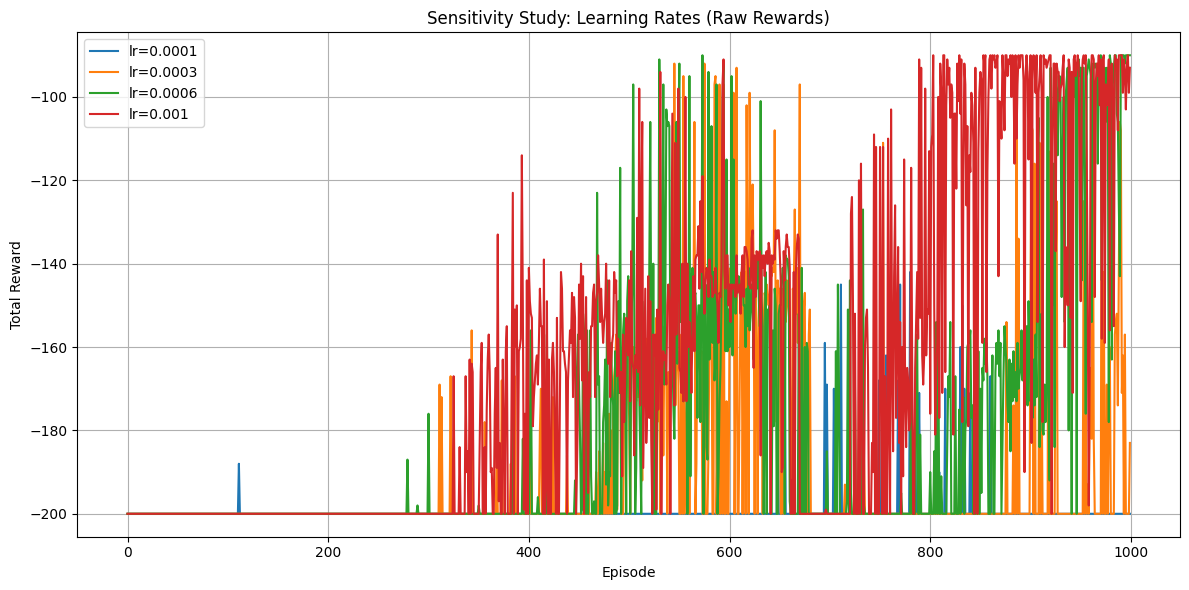

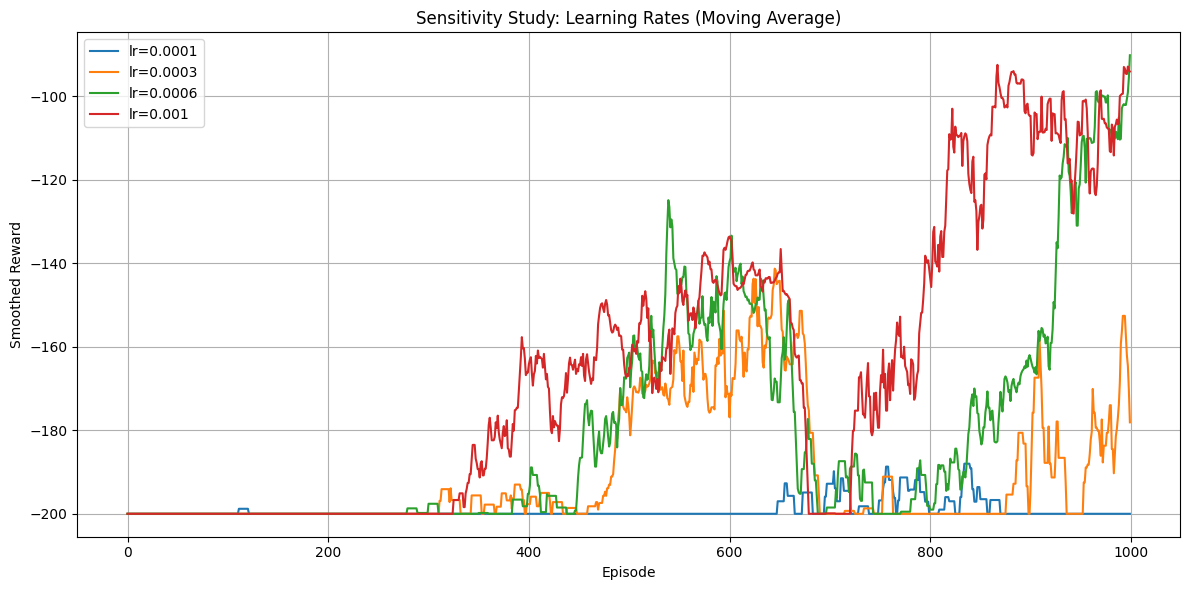


--- Gamma = 0.9 ---
Episode 0, Reward: -200.00, Epsilon: 0.995
Episode 1, Reward: -200.00, Epsilon: 0.990
Episode 2, Reward: -200.00, Epsilon: 0.985
Episode 3, Reward: -200.00, Epsilon: 0.980
Episode 4, Reward: -200.00, Epsilon: 0.975
Episode 5, Reward: -200.00, Epsilon: 0.970
Episode 6, Reward: -200.00, Epsilon: 0.966
Episode 7, Reward: -200.00, Epsilon: 0.961
Episode 8, Reward: -200.00, Epsilon: 0.956
Episode 9, Reward: -200.00, Epsilon: 0.951
Episode 10, Reward: -200.00, Epsilon: 0.946
Episode 11, Reward: -200.00, Epsilon: 0.942
Episode 12, Reward: -200.00, Epsilon: 0.937
Episode 13, Reward: -200.00, Epsilon: 0.932
Episode 14, Reward: -200.00, Epsilon: 0.928
Episode 15, Reward: -200.00, Epsilon: 0.923
Episode 16, Reward: -200.00, Epsilon: 0.918
Episode 17, Reward: -200.00, Epsilon: 0.914
Episode 18, Reward: -200.00, Epsilon: 0.909
Episode 19, Reward: -200.00, Epsilon: 0.905
Episode 20, Reward: -200.00, Epsilon: 0.900
Episode 21, Reward: -200.00, Epsilon: 0.896
Episode 22, Reward: -

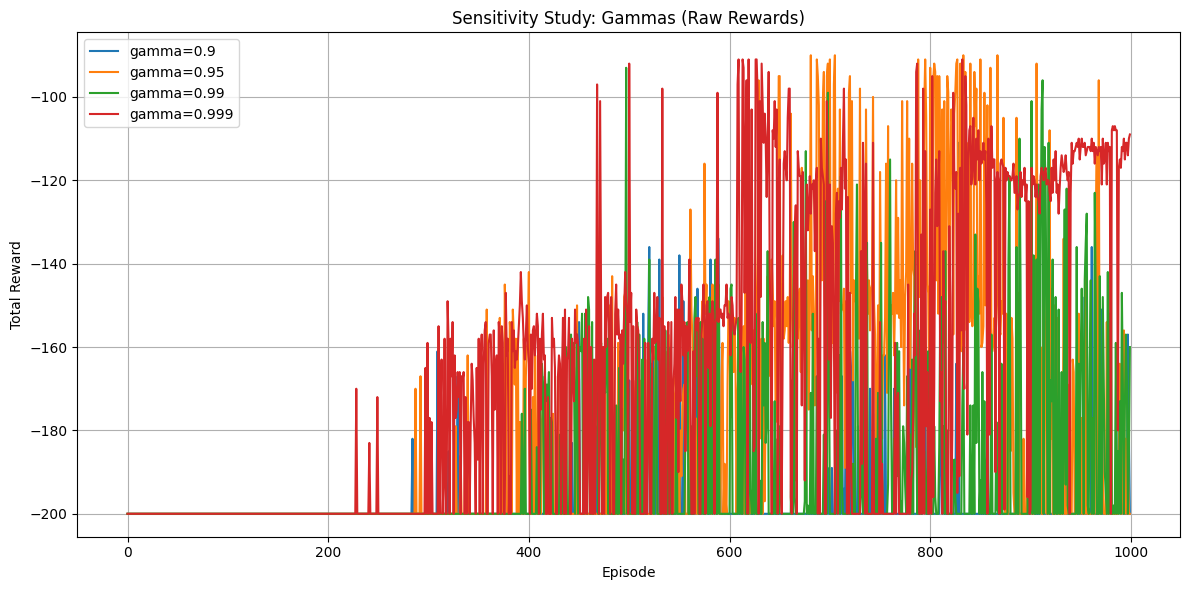

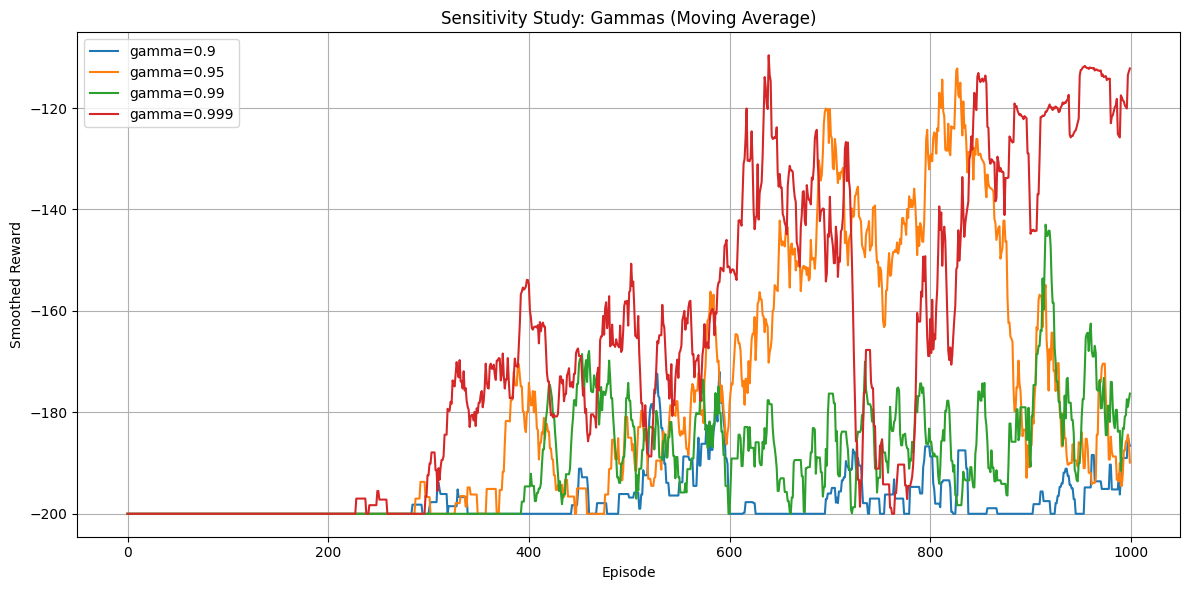


--- Batch Size = 32 ---
Episode 0, Reward: -200.00, Epsilon: 0.995
Episode 1, Reward: -200.00, Epsilon: 0.990
Episode 2, Reward: -200.00, Epsilon: 0.985
Episode 3, Reward: -200.00, Epsilon: 0.980
Episode 4, Reward: -200.00, Epsilon: 0.975
Episode 5, Reward: -200.00, Epsilon: 0.970
Episode 6, Reward: -200.00, Epsilon: 0.966
Episode 7, Reward: -200.00, Epsilon: 0.961
Episode 8, Reward: -200.00, Epsilon: 0.956
Episode 9, Reward: -200.00, Epsilon: 0.951
Episode 10, Reward: -200.00, Epsilon: 0.946
Episode 11, Reward: -200.00, Epsilon: 0.942
Episode 12, Reward: -200.00, Epsilon: 0.937
Episode 13, Reward: -200.00, Epsilon: 0.932
Episode 14, Reward: -200.00, Epsilon: 0.928
Episode 15, Reward: -200.00, Epsilon: 0.923
Episode 16, Reward: -200.00, Epsilon: 0.918
Episode 17, Reward: -200.00, Epsilon: 0.914
Episode 18, Reward: -200.00, Epsilon: 0.909
Episode 19, Reward: -200.00, Epsilon: 0.905
Episode 20, Reward: -200.00, Epsilon: 0.900
Episode 21, Reward: -200.00, Epsilon: 0.896
Episode 22, Rewar

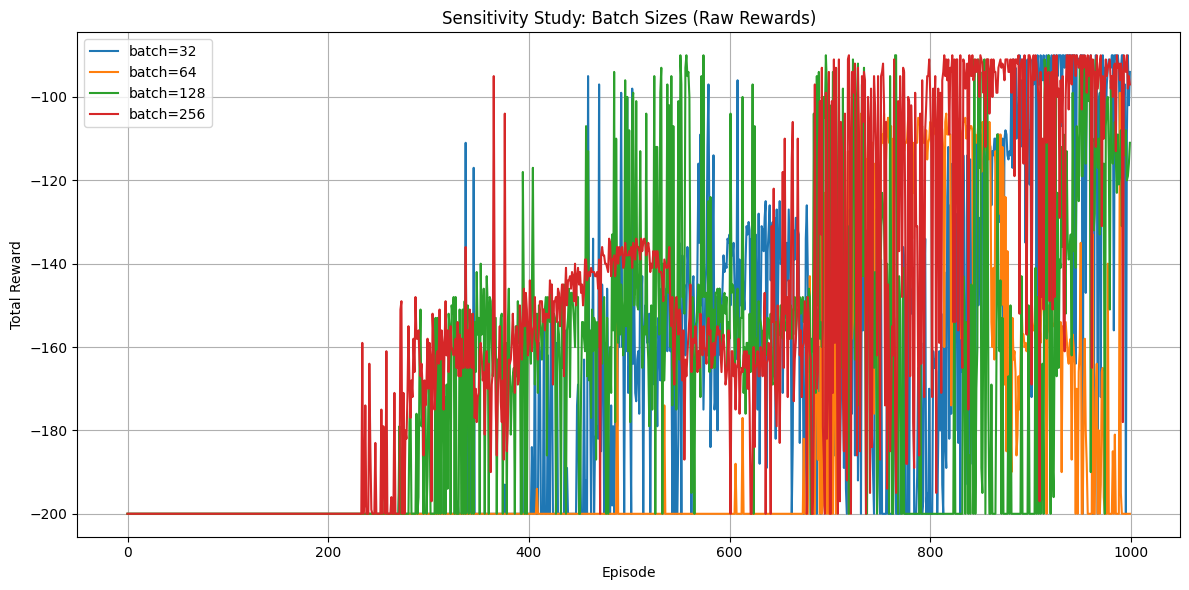

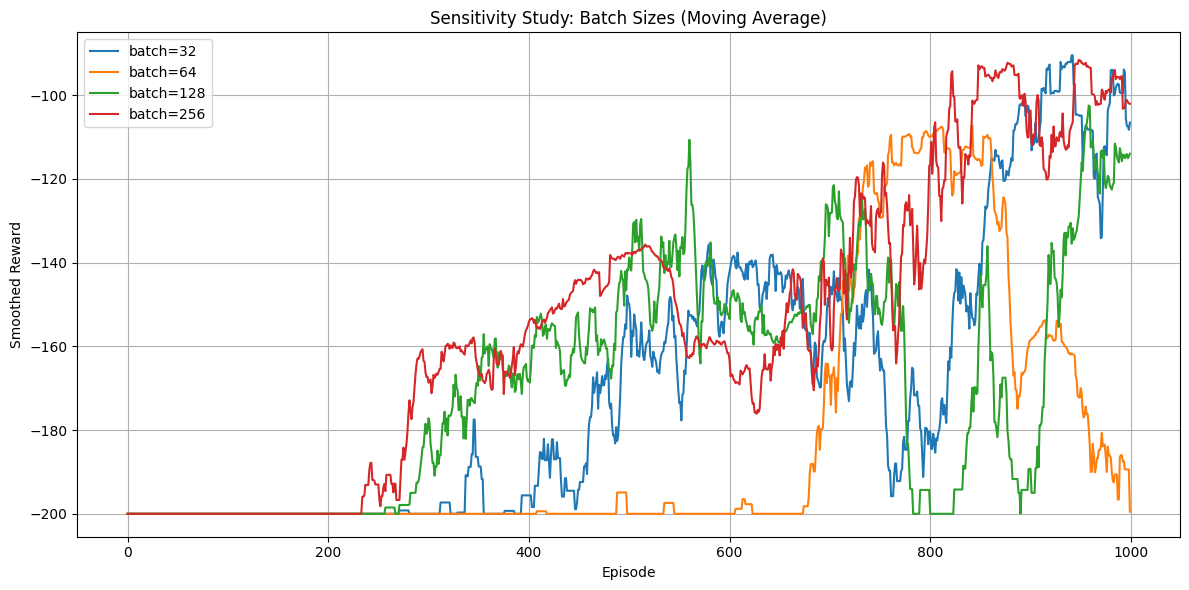


--- Epsilon Decay = 0.98 ---
Episode 0, Reward: -200.00, Epsilon: 0.980
Episode 1, Reward: -200.00, Epsilon: 0.960
Episode 2, Reward: -200.00, Epsilon: 0.941
Episode 3, Reward: -200.00, Epsilon: 0.922
Episode 4, Reward: -200.00, Epsilon: 0.904
Episode 5, Reward: -200.00, Epsilon: 0.886
Episode 6, Reward: -200.00, Epsilon: 0.868
Episode 7, Reward: -200.00, Epsilon: 0.851
Episode 8, Reward: -200.00, Epsilon: 0.834
Episode 9, Reward: -200.00, Epsilon: 0.817
Episode 10, Reward: -200.00, Epsilon: 0.801
Episode 11, Reward: -200.00, Epsilon: 0.785
Episode 12, Reward: -200.00, Epsilon: 0.769
Episode 13, Reward: -200.00, Epsilon: 0.754
Episode 14, Reward: -200.00, Epsilon: 0.739
Episode 15, Reward: -200.00, Epsilon: 0.724
Episode 16, Reward: -200.00, Epsilon: 0.709
Episode 17, Reward: -200.00, Epsilon: 0.695
Episode 18, Reward: -200.00, Epsilon: 0.681
Episode 19, Reward: -200.00, Epsilon: 0.668
Episode 20, Reward: -200.00, Epsilon: 0.654
Episode 21, Reward: -200.00, Epsilon: 0.641
Episode 22, 

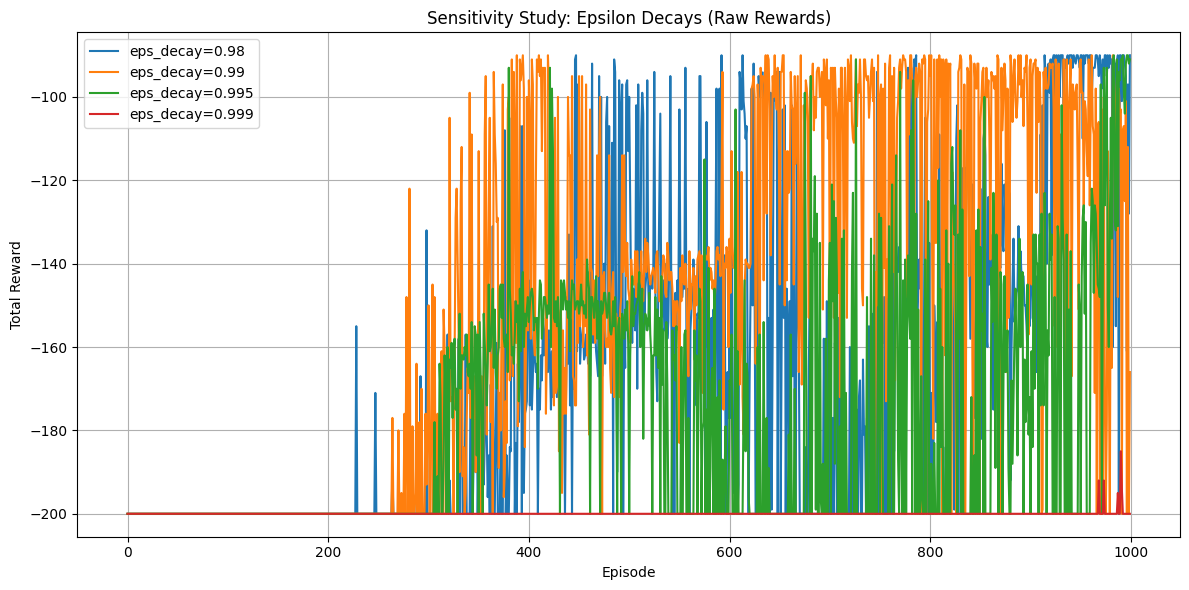

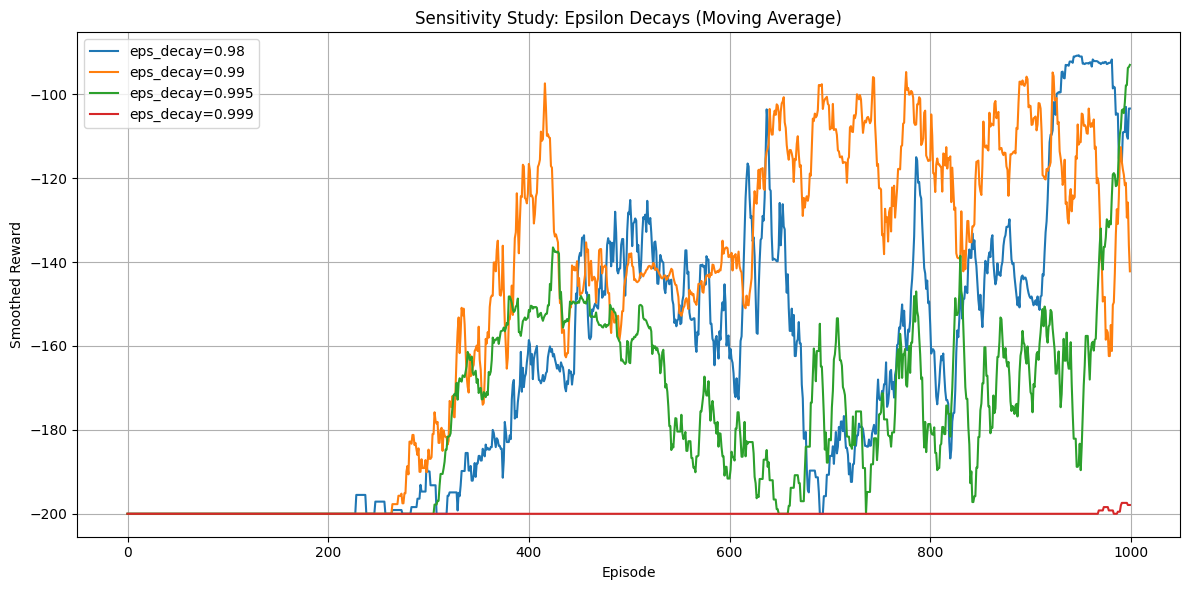

In [ ]:
#double dqn 4 parameters

import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Neural Network
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size=64):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (
            torch.tensor(state, dtype=torch.float32).to(device),
            torch.tensor(action).to(device),
            torch.tensor(reward).to(device),
            torch.tensor(next_state, dtype=torch.float32).to(device),
            torch.tensor(done, dtype=torch.float32).to(device)
        )

    def __len__(self):
        return len(self.buffer)

#policy
def select_action(state, policy_net, epsilon, action_space):
    if random.random() < epsilon:
        return action_space.sample()
    else:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            q_values = policy_net(state_tensor)
            return q_values.argmax().item()


# Training Loop
def train_dqn(
    env,
    episodes=1000,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995,
    learning_rate=1e-3,
    target_update=10,
    batch_size=128
):
    obs_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    policy_net = DQN(obs_dim, n_actions).to(device)
    target_net = DQN(obs_dim, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    replay_buffer = ReplayBuffer()

    epsilon = epsilon_start
    rewards_per_episode = []

    for episode in range(episodes):
        state, _ = env.reset(seed=SEED)
        total_reward = 0

        while True:
            action = select_action(state, policy_net, epsilon, env.action_space)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(replay_buffer) >= batch_size:
                s_batch, a_batch, r_batch, ns_batch, d_batch = replay_buffer.sample(batch_size)

                #Q(s,a) από policy_net
                q_values = policy_net(s_batch).gather(1, a_batch.unsqueeze(1)).squeeze(1)

                #Double DQN target
                with torch.no_grad():
                    next_actions = policy_net(ns_batch).argmax(1)
                    next_q_values = target_net(ns_batch).gather(
                        1, next_actions.unsqueeze(1)
                    ).squeeze(1)

                target_q = r_batch + gamma * next_q_values * (1 - d_batch)

                loss = nn.MSELoss()(q_values, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)

        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        print(f"Episode {episode}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")

    return rewards_per_episode




def plot_rewards_mean(rewards, d):
    m = []
    for i in range(len(rewards)):
        if i < d:
            m.append(np.mean(rewards[:i+1]))
        else:
            m.append(np.mean(rewards[i-d+1:i+1]))
    return m


def plot_rewards(results_dict, title, avg_window=10):
    # Plot 1
    plt.figure(figsize=(12, 6))
    for label, rewards in results_dict.items():
        plt.plot(rewards, label=label)
    plt.title(f"{title} (Raw Rewards)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_').lower()}_raw.png")
    plt.show()

    #Plot 2
    plt.figure(figsize=(12, 6))
    for label, rewards in results_dict.items():
        smooth = plot_rewards_mean(rewards, avg_window)
        plt.plot(smooth, label=label)
    plt.title(f"{title} (Moving Average)")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_').lower()}_avg.png")
    plt.show()

if __name__ == "__main__":
    env = gym.make("MountainCar-v0")
    env.action_space.seed(SEED)


    base_lr = 0.001
    base_gamma = 0.99
    base_batch_size = 64
    base_epsilon_decay = 0.995

    #Learning Rates
    learning_rates = [0.0001, 0.0003, 0.0006, 0.001]
    lr_results = {}
    for lr in learning_rates:
        print(f"\n--- Learning Rate = {lr} ---")
        rewards = train_dqn(env, learning_rate=lr, gamma=base_gamma,
                            batch_size=base_batch_size, epsilon_decay=base_epsilon_decay)
        lr_results[f"lr={lr}"] = rewards
    plot_rewards(lr_results, "Sensitivity Study: Learning Rates")

    #Gammas
    gammas = [0.9, 0.95, 0.99, 0.999]
    gamma_results = {}
    for g in gammas:
        print(f"\n--- Gamma = {g} ---")
        rewards = train_dqn(env, learning_rate=base_lr, gamma=g,
                            batch_size=base_batch_size, epsilon_decay=base_epsilon_decay)
        gamma_results[f"gamma={g}"] = rewards
    plot_rewards(gamma_results, "Sensitivity Study: Gammas")

    #Batch Sizes
    batch_sizes = [32, 64, 128, 256]
    batch_results = {}
    for b in batch_sizes:
        print(f"\n--- Batch Size = {b} ---")
        rewards = train_dqn(env, learning_rate=base_lr, gamma=base_gamma,
                            batch_size=b, epsilon_decay=base_epsilon_decay)
        batch_results[f"batch={b}"] = rewards
    plot_rewards(batch_results, "Sensitivity Study: Batch Sizes")

   #Epsilon Decays
    epsilon_decays = [0.98, 0.99, 0.995, 0.999]
    eps_results = {}
    for e in epsilon_decays:
        print(f"\n--- Epsilon Decay = {e} ---")
        rewards = train_dqn(env, learning_rate=base_lr, gamma=base_gamma,
                            batch_size=base_batch_size, epsilon_decay=e)
        eps_results[f"eps_decay={e}"] = rewards
    plot_rewards(eps_results, "Sensitivity Study: Epsilon Decays")

    env.close()

In [ ]:
# DRQN (LSTM-DQN)


import gymnasium as gym
import numpy as np
import random
import collections
from typing import Dict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt



SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



class Q_net(nn.Module):
    def __init__(self, state_space=None, action_space=None, hidden_space=128):
        super(Q_net, self).__init__()
        self.action_space = action_space
        self.hidden_space = hidden_space
        self.state_space  = state_space

        self.layer1       = nn.Linear(self.state_space, self.hidden_space)
        self.lstm         = nn.LSTM(self.hidden_space, self.hidden_space, batch_first=True)
        self.layer2       = nn.Linear(self.hidden_space, self.action_space)

    def forward(self, x, h, c):
        x                 = F.relu(self.layer1(x))
        x, (new_h, new_c) = self.lstm(x, (h, c))
        q_seq             = self.layer2(x)
        return q_seq, new_h, new_c

    @torch.no_grad()
    def sample_action(self, observation, h, c, epsilon, action_space_n):
        if random.random() < epsilon:
            a = random.randrange(action_space_n)
            return a, h, c
        out, new_h, new_c = self.forward(observation, h, c)
        a = out.squeeze(0).squeeze(0).argmax().item()
        return a, new_h, new_c

    def init_hidden_state(self, batch_size, training=None):
        if training:
            return (torch.zeros(1, batch_size, self.hidden_space, device=device),
                    torch.zeros(1, batch_size, self.hidden_space, device=device))
        else:
            return (torch.zeros(1, 1, self.hidden_space, device=device),
                    torch.zeros(1, 1, self.hidden_space, device=device))

class EpisodeBuffer:
    def __init__(self):
        self.observation = []
        self.action      = []
        self.reward      = []
        self.next_obs    = []
        self.done        = []

    def put(self, transition):
        self.observation.append(transition[0])
        self.action.append(transition[1])
        self.reward.append(transition[2])
        self.next_obs.append(transition[3])
        self.done.append(transition[4])

    def sample(self, random_update=False, lookup_step=None, idx=None) -> Dict[str, np.ndarray]:
        observation = np.array(self.observation, dtype=np.float32)
        action      = np.array(self.action, dtype=np.int64)
        reward      = np.array(self.reward, dtype=np.float32)
        next_obs    = np.array(self.next_obs, dtype=np.float32)
        done        = np.array(self.done, dtype=np.float32)

        if random_update is True:
            observation = observation[idx:idx+lookup_step]
            action      = action[idx:idx+lookup_step]
            reward      = reward[idx:idx+lookup_step]
            next_obs    = next_obs[idx:idx+lookup_step]
            done        = done[idx:idx+lookup_step]

        return dict(observation=observation, acts=action, rews=reward, next_obs=next_obs, done=done)

    def __len__(self) -> int:
        return len(self.observation)

class EpisodeMemory:
    def __init__(self, random_update=False, max_epi_num=100, max_epi_len=200, batch_size=32, lookup_step=30):
        self.random_update = random_update
        self.max_epi_num   = max_epi_num
        self.max_epi_len   = max_epi_len
        self.batch_size    = batch_size
        self.lookup_step   = lookup_step
        self.memory        = collections.deque(maxlen=self.max_epi_num)

    def put(self, episode: EpisodeBuffer):
        self.memory.append(episode)

    def sample(self):
        assert len(self.memory) > 0
        sampled_buffer = []

        if self.random_update:
            sampled_episodes = random.sample(self.memory, self.batch_size)
            L = self.lookup_step
            for ep in sampled_episodes:
                if len(ep) < L:
                    idx = 0
                    sample = ep.sample(random_update=True, lookup_step=len(ep), idx=idx)
                    pad_len = L - len(ep)
                    for k in ("observation", "acts", "rews", "next_obs", "done"):
                        sample[k] = self._pad_sequence(sample[k], L, key=k)
                    sampled_buffer.append(sample)
                else:
                    idx = np.random.randint(0, len(ep) - L + 1)
                    sample = ep.sample(random_update=True, lookup_step=L, idx=idx)
                    sampled_buffer.append(sample)
            seq_len = self.lookup_step
        else:
            ep = random.choice(self.memory)
            sample = ep.sample(random_update=False)
            sampled_buffer.append(sample)
            seq_len = len(sample["observation"])

        return sampled_buffer, seq_len

    def _pad_sequence(self, arr, L, key="observation"):
        if arr.ndim == 1:
            out = np.zeros((L,), dtype=arr.dtype)
            out[:len(arr)] = arr
            out[len(arr):] = arr[-1]
            return out
        else:
            d = arr.shape[1]
            out = np.zeros((L, d), dtype=arr.dtype)
            out[:len(arr), :] = arr
            out[len(arr):, :] = arr[-1, :]
            return out

    def __len__(self):
        return len(self.memory)


def get_observation_fully_observable(state):
    return state

def get_observation_pomdp(state):
    return np.array([state[0]], dtype=np.float32)


def get_observation_noisy_pomdp(state, noise_std=0.01):
    noise = np.random.normal(0, noise_std)
    return np.array([state[0] + noise], dtype=np.float32)





def convert_data(data, batch_size, seq_len):
    data = np.array(data, dtype=np.float32)                    # (B, S, d) ή (B,S)
    return torch.tensor(data.reshape(batch_size, seq_len, -1), dtype=torch.float32, device=device)

def compute_rolling_average(rewards, window_size=10):
    return [np.mean(rewards[max(0, i - window_size + 1): i + 1]) for i in range(len(rewards))]

def plot_single_reward(rewards, title, window_size=10):
    avg = compute_rolling_average(rewards, window_size)
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label="Episode Reward", color="skyblue", alpha=0.35)
    plt.plot(avg, label=f"Moving Avg ({window_size})", color="darkblue", linewidth=2)
    plt.title(title)
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def train_step(q_net, target_q_net, episode_memory, optimizer, gamma=0.99, grad_clip=5.0):
    samples, seq_len = episode_memory.sample()

    B = len(samples)
    observations      = []
    actions           = []
    rewards           = []
    next_observations = []
    dones             = []

    for i in range(B):
        observations.append(samples[i]["observation"])
        actions.append(samples[i]["acts"])
        rewards.append(samples[i]["rews"])
        next_observations.append(samples[i]["next_obs"])
        dones.append(samples[i]["done"])



    observations      = convert_data(observations, B, seq_len)
    rewards           = convert_data(rewards, B, seq_len)
    next_observations = convert_data(next_observations, B, seq_len)
    dones             = convert_data(dones, B, seq_len)

    rewards = rewards.squeeze(-1)
    dones   = dones.squeeze(-1)
    actions = np.array(actions, dtype=np.int64).reshape(B, seq_len, 1)
    actions = torch.tensor(actions, dtype=torch.long, device=device)

    #Target Q
    h_t, c_t  = target_q_net.init_hidden_state(batch_size=B, training=True)
    q_target, _, _  = target_q_net(next_observations, h_t, c_t)
    next_q_max      = q_target.max(dim=2, keepdim=True)[0]
    target_q_values = rewards.unsqueeze(-1) + gamma * next_q_max * dones.unsqueeze(-1)

    #Current Q(s,a)
    h, c        = q_net.init_hidden_state(batch_size=B, training=True)
    q_out, _, _ = q_net(observations, h, c)
    q_sa        = q_out.gather(2, actions)

    loss = F.smooth_l1_loss(q_sa, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(q_net.parameters(), grad_clip)
    optimizer.step()

def train_drqn(env,
               observation_function,
               num_episodes=900,
               max_step=200,
               batch_size=32,
               learning_rate=1e-3,
               gamma=0.99,
               eps_start=1.0,
               eps_end=0.01,
               eps_decay=0.995,
               target_update_frequency=10,
               tau=0.05,
               random_update=True,
               lookup_step=30,
               min_epi_num=32,
               verbose=True):

    input_dim  = env.observation_space.shape[0]
    output_dim = env.action_space.n

    q_net      = Q_net(input_dim, output_dim, hidden_space=128).to(device)
    target_net = Q_net(input_dim, output_dim, hidden_space=128).to(device)
    target_net.load_state_dict(q_net.state_dict())

    optimizer = optim.Adam(q_net.parameters(), lr=learning_rate)

    episode_memory = EpisodeMemory(random_update=random_update,
                                   max_epi_num=100,
                                   max_epi_len=max_step,
                                   batch_size=batch_size,
                                   lookup_step=lookup_step)

    epsilon = eps_start
    rewards = []

    for ep in range(1, num_episodes + 1):
        state, _      = env.reset(seed=SEED)
        obs           = observation_function(state).astype(np.float32)
        done          = False
        ep_rew        = 0.0
        ep_buf        = EpisodeBuffer()
        h, c          = q_net.init_hidden_state(batch_size=1, training=False)

        for t in range(max_step):
            obs_t = torch.from_numpy(obs).float().to(device).unsqueeze(0).unsqueeze(0)  # (1,1,obs_dim)
            action, h, c = q_net.sample_action(obs_t, h, c, epsilon, output_dim)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_obs = observation_function(next_state).astype(np.float32)

            not_done = 0.0 if done else 1.0

            ep_buf.put([obs, action, reward / 100.0, next_obs, not_done])

            obs    = next_obs
            ep_rew += reward
            if done:
                break



            if len(episode_memory) >= min_epi_num and (t + 1) % target_update_frequency == 0:
                train_step(q_net, target_net, episode_memory, optimizer, gamma=gamma)


                with torch.no_grad():
                    for p_t, p in zip(target_net.parameters(), q_net.parameters()):
                        p_t.data.copy_(tau * p.data + (1.0 - tau) * p_t.data)


        epsilon = max(eps_end, epsilon * eps_decay)

        episode_memory.put(ep_buf)
        rewards.append(ep_rew)

        if verbose and ep % 10 == 0:
            avg = np.mean(rewards[-10:])
            print(f"Episode {ep}, Reward(avg last 10): {avg:.2f}, Epsilon: {epsilon:.3f}")

    return rewards


if __name__ == "__main__":
    env = gym.make("MountainCar-v0")
    env.action_space.seed(SEED)

    rewards = train_drqn(
        env=env,
        observation_function=get_observation_fully_observable,
        num_episodes=900,
        max_step=200,
        batch_size=32,
        learning_rate=1e-3,
        gamma=0.99,
        eps_start=1.0,
        eps_end=0.01,
        eps_decay=0.995,
        target_update_frequency=10,
        tau=0.05,
        random_update=True,
        lookup_step=30,
        min_epi_num=32,
        verbose=True
    )


    plt.figure(figsize=(10, 5))
    avg = compute_rolling_average(rewards, window_size=10)
    plt.plot(rewards, label="Episode Reward", color="skyblue", alpha=0.4)
    plt.plot(avg, label="Moving Avg (window=10)", color="darkblue", linewidth=2)
    plt.title("DRQN (LSTM-DQN) on MountainCar-v0")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    env.close()

Ep    0 | Ret: -200.00 | eps: 0.999
Ep    1 | Ret: -200.00 | eps: 0.998
Ep    2 | Ret: -200.00 | eps: 0.997
Ep    3 | Ret: -200.00 | eps: 0.996
Ep    4 | Ret: -200.00 | eps: 0.995
Ep    5 | Ret: -200.00 | eps: 0.994
Ep    6 | Ret: -200.00 | eps: 0.993
Ep    7 | Ret: -200.00 | eps: 0.992
Ep    8 | Ret: -200.00 | eps: 0.991
Ep    9 | Ret: -200.00 | eps: 0.990
Ep   10 | Ret: -200.00 | eps: 0.989
Ep   11 | Ret: -200.00 | eps: 0.988
Ep   12 | Ret: -200.00 | eps: 0.987
Ep   13 | Ret: -200.00 | eps: 0.986
Ep   14 | Ret: -200.00 | eps: 0.985
Ep   15 | Ret: -200.00 | eps: 0.984
Ep   16 | Ret: -200.00 | eps: 0.983
Ep   17 | Ret: -200.00 | eps: 0.982
Ep   18 | Ret: -200.00 | eps: 0.981
Ep   19 | Ret: -200.00 | eps: 0.980
Ep   20 | Ret: -200.00 | eps: 0.979
Ep   21 | Ret: -200.00 | eps: 0.978
Ep   22 | Ret: -200.00 | eps: 0.977
Ep   23 | Ret: -200.00 | eps: 0.976
Ep   24 | Ret: -200.00 | eps: 0.975
Ep   25 | Ret: -200.00 | eps: 0.974
Ep   26 | Ret: -200.00 | eps: 0.973
Ep   27 | Ret: -200.00 | eps

Using device: cuda
Episode 0, Reward: -200.00, Epsilon: 0.995
Episode 1, Reward: -200.00, Epsilon: 0.990
Episode 2, Reward: -200.00, Epsilon: 0.985
Episode 3, Reward: -200.00, Epsilon: 0.980
Episode 4, Reward: -200.00, Epsilon: 0.975
Episode 5, Reward: -200.00, Epsilon: 0.970
Episode 6, Reward: -200.00, Epsilon: 0.966
Episode 7, Reward: -200.00, Epsilon: 0.961
Episode 8, Reward: -200.00, Epsilon: 0.956
Episode 9, Reward: -200.00, Epsilon: 0.951
Episode 10, Reward: -200.00, Epsilon: 0.946
Episode 11, Reward: -200.00, Epsilon: 0.942
Episode 12, Reward: -200.00, Epsilon: 0.937
Episode 13, Reward: -200.00, Epsilon: 0.932
Episode 14, Reward: -200.00, Epsilon: 0.928
Episode 15, Reward: -200.00, Epsilon: 0.923
Episode 16, Reward: -200.00, Epsilon: 0.918
Episode 17, Reward: -200.00, Epsilon: 0.914
Episode 18, Reward: -200.00, Epsilon: 0.909
Episode 19, Reward: -200.00, Epsilon: 0.905
Episode 20, Reward: -200.00, Epsilon: 0.900
Episode 21, Reward: -200.00, Epsilon: 0.896
Episode 22, Reward: -20

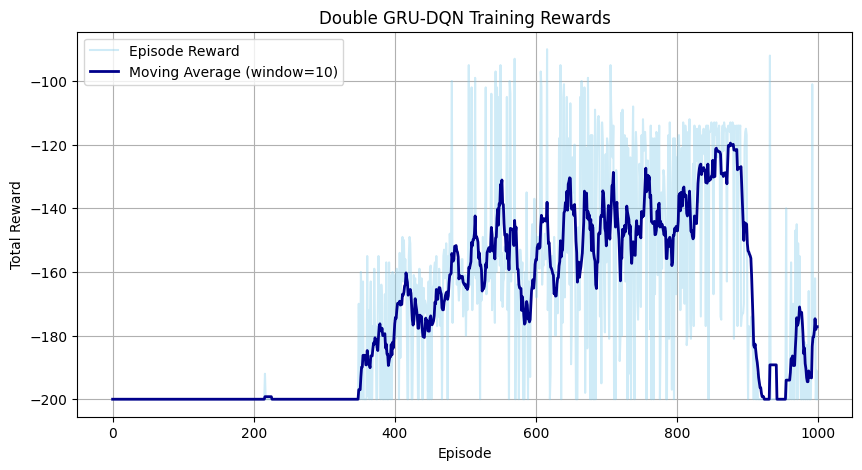

In [ ]:
# DRQN (LSTM-DQN) 4 parameters

import gymnasium as gym
import numpy as np
import random
import collections
from typing import Dict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


class Q_net(nn.Module):
    def __init__(self, state_space=None, action_space=None, hidden_space=128):
        super(Q_net, self).__init__()
        self.action_space = action_space
        self.hidden_space = hidden_space
        self.state_space  = state_space
        self.layer1 = nn.Linear(self.state_space, self.hidden_space)
        self.lstm   = nn.LSTM(self.hidden_space, self.hidden_space, batch_first=True)
        self.layer2 = nn.Linear(self.hidden_space, self.action_space)

    def forward(self, x, h, c):
        x = F.relu(self.layer1(x))
        x, (new_h, new_c) = self.lstm(x, (h, c))
        q_seq = self.layer2(x)
        return q_seq, new_h, new_c

    @torch.no_grad()
    def sample_action(self, observation, h, c, epsilon, action_space_n):
        if random.random() < epsilon:
            a = random.randrange(action_space_n)
            return a, h, c
        out, new_h, new_c = self.forward(observation, h, c)
        a = out.squeeze(0).squeeze(0).argmax().item()
        return a, new_h, new_c

    def init_hidden_state(self, batch_size, training=None):
        if training:
            return (torch.zeros(1, batch_size, self.hidden_space, device=device),
                    torch.zeros(1, batch_size, self.hidden_space, device=device))
        else:
            return (torch.zeros(1, 1, self.hidden_space, device=device),
                    torch.zeros(1, 1, self.hidden_space, device=device))

class EpisodeBuffer:
    def __init__(self):
        self.observation = []
        self.action      = []
        self.reward      = []
        self.next_obs    = []
        self.done        = []

    def put(self, transition):
        self.observation.append(transition[0])
        self.action.append(transition[1])
        self.reward.append(transition[2])
        self.next_obs.append(transition[3])
        self.done.append(transition[4])

    def sample(self, random_update=False, lookup_step=None, idx=None) -> Dict[str, np.ndarray]:
        observation = np.array(self.observation, dtype=np.float32)
        action      = np.array(self.action, dtype=np.int64)
        reward      = np.array(self.reward, dtype=np.float32)
        next_obs    = np.array(self.next_obs, dtype=np.float32)
        done        = np.array(self.done, dtype=np.float32)
        if random_update is True:
            observation = observation[idx:idx+lookup_step]
            action      = action[idx:idx+lookup_step]
            reward      = reward[idx:idx+lookup_step]
            next_obs    = next_obs[idx:idx+lookup_step]
            done        = done[idx:idx+lookup_step]
        return dict(observation=observation, acts=action, rews=reward, next_obs=next_obs, done=done)

    def __len__(self) -> int:
        return len(self.observation)

class EpisodeMemory:
    def __init__(self, random_update=False, max_epi_num=100, max_epi_len=200, batch_size=32, lookup_step=30):
        self.random_update = random_update
        self.max_epi_num   = max_epi_num
        self.max_epi_len   = max_epi_len
        self.batch_size    = batch_size
        self.lookup_step   = lookup_step
        self.memory        = collections.deque(maxlen=self.max_epi_num)

    def put(self, episode: EpisodeBuffer):
        self.memory.append(episode)

    def sample(self):
        assert len(self.memory) > 0
        sampled_buffer = []
        if self.random_update:
            sampled_episodes = random.sample(self.memory, self.batch_size)
            L = self.lookup_step
            for ep in sampled_episodes:
                if len(ep) < L:
                    idx = 0
                    sample = ep.sample(True, len(ep), idx)
                    for k in ("observation","acts","rews","next_obs","done"):
                        sample[k] = self._pad_sequence(sample[k], L, key=k)
                    sampled_buffer.append(sample)
                else:
                    idx = np.random.randint(0, len(ep) - L + 1)
                    sample = ep.sample(True, L, idx)
                    sampled_buffer.append(sample)
            seq_len = self.lookup_step
        else:
            ep = random.choice(self.memory)
            sample = ep.sample(False)
            sampled_buffer.append(sample)
            seq_len = len(sample["observation"])
        return sampled_buffer, seq_len

    def _pad_sequence(self, arr, L, key="observation"):
        if arr.ndim == 1:
            out = np.zeros((L,), dtype=arr.dtype)
            out[:len(arr)] = arr
            out[len(arr):] = arr[-1]
            return out
        else:
            d = arr.shape[1]
            out = np.zeros((L, d), dtype=arr.dtype)
            out[:len(arr), :] = arr
            out[len(arr):, :] = arr[-1, :]
            return out

    def __len__(self):
        return len(self.memory)

def get_observation_fully_observable(state):
    return state.astype(np.float32)

def get_observation_pomdp(state):
    return np.array([state[0]], dtype=np.float32)

def get_observation_noisy_pomdp(state, noise_std=0.01):
    return np.array([state[0] + np.random.normal(0, noise_std)], dtype=np.float32)


def compute_rolling_average(rewards, window_size=10):
    return [np.mean(rewards[max(0, i - window_size + 1): i + 1]) for i in range(len(rewards))]

def plot_results(results_dict, title, avg_window=10):
    plt.figure(figsize=(12,6))
    for label, rewards in results_dict.items():
        plt.plot(rewards, label=label, alpha=0.35)
    plt.title(f"{title} (Raw Rewards)")
    plt.xlabel("Episodes"); plt.ylabel("Total Reward")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
    plt.figure(figsize=(12,6))
    for label, rewards in results_dict.items():
        smooth = compute_rolling_average(rewards, window_size=avg_window)
        plt.plot(smooth, label=label)
    plt.title(f"{title} (Moving Average)")
    plt.xlabel("Episodes"); plt.ylabel("Smoothed Reward")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


def _to_seq_tensor(data_list, B, S):
    data = np.array(data_list, dtype=np.float32)
    return torch.tensor(data.reshape(B, S, -1), dtype=torch.float32, device=device)

def train_step(q_net, target_q_net, episode_memory, optimizer, gamma=0.99, grad_clip=5.0):
    samples, seq_len = episode_memory.sample()
    B = len(samples)

    observations, actions, rewards, next_observations, dones = [], [], [], [], []
    for i in range(B):
        observations.append(samples[i]["observation"])
        actions.append(samples[i]["acts"])
        rewards.append(samples[i]["rews"])
        next_observations.append(samples[i]["next_obs"])
        dones.append(samples[i]["done"])

    observations      = _to_seq_tensor(observations, B, seq_len)
    next_observations = _to_seq_tensor(next_observations, B, seq_len)
    rewards           = _to_seq_tensor(rewards, B, seq_len).squeeze(-1)
    dones             = _to_seq_tensor(dones, B, seq_len).squeeze(-1)
    actions           = torch.tensor(np.array(actions, dtype=np.int64).reshape(B, seq_len, 1),
                                     dtype=torch.long, device=device)

    #Target Q
    h_t, c_t  = target_q_net.init_hidden_state(batch_size=B, training=True)
    q_target, _, _  = target_q_net(next_observations, h_t, c_t)
    next_q_max      = q_target.max(dim=2, keepdim=True)[0]
    target_q_values = rewards.unsqueeze(-1) + gamma * next_q_max * dones.unsqueeze(-1)

    #Current Q(s,a)
    h, c        = q_net.init_hidden_state(batch_size=B, training=True)
    q_out, _, _ = q_net(observations, h, c)
    q_sa        = q_out.gather(2, actions)

    loss = F.smooth_l1_loss(q_sa, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(q_net.parameters(), grad_clip)
    optimizer.step()

# --------------------
# Main DRQN training
# --------------------
def train_drqn(env,
               observation_function,
               num_episodes=600,
               max_step=200,
               batch_size=32,
               learning_rate=1e-3,
               gamma=0.99,
               eps_start=1.0,
               eps_end=0.01,
               eps_decay=0.995,
               target_update_frequency=10,
               tau=0.05,
               random_update=True,
               lookup_step=30,
               min_epi_num=32,
               verbose=True):

    input_dim  = env.observation_space.shape[0]
    output_dim = env.action_space.n

    q_net      = Q_net(input_dim, output_dim, hidden_space=128).to(device)
    target_net = Q_net(input_dim, output_dim, hidden_space=128).to(device)
    target_net.load_state_dict(q_net.state_dict())

    optimizer = optim.Adam(q_net.parameters(), lr=learning_rate)

    episode_memory = EpisodeMemory(random_update=random_update,
                                   max_epi_num=100,
                                   max_epi_len=max_step,
                                   batch_size=batch_size,
                                   lookup_step=lookup_step)

    epsilon = eps_start
    rewards = []

    for ep in range(1, num_episodes + 1):
        state, _ = env.reset(seed=SEED)
        obs = observation_function(state)
        done = False
        ep_rew = 0.0
        ep_buf = EpisodeBuffer()
        h, c = q_net.init_hidden_state(batch_size=1, training=False)

        for t in range(max_step):
            obs_t = torch.from_numpy(obs).float().to(device).unsqueeze(0).unsqueeze(0)
            action, h, c = q_net.sample_action(obs_t, h, c, epsilon, output_dim)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_obs = observation_function(next_state)
            not_done = 0.0 if done else 1.0


            ep_buf.put([obs, action, reward / 100.0, next_obs, not_done])

            obs = next_obs
            ep_rew += reward
            if done:
                break

            # updates
            if len(episode_memory) >= min_epi_num and (t + 1) % target_update_frequency == 0:
                train_step(q_net, target_net, episode_memory, optimizer, gamma=gamma)
                with torch.no_grad():
                    for p_t, p in zip(target_net.parameters(), q_net.parameters()):
                        p_t.data.copy_(tau * p.data + (1.0 - tau) * p_t.data)

        epsilon = max(eps_end, epsilon * eps_decay)
        episode_memory.put(ep_buf)
        rewards.append(ep_rew)

        if verbose and ep % 10 == 0:
            avg = np.mean(rewards[-10:])
            print(f"Episode {ep}, Reward: {avg:.2f}, Epsilon: {epsilon:.3f}")

    return rewards


def sweep_and_plot(param_name, values, base_kwargs, title, avg_window=10):
    results = {}
    for v in values:
        kwargs = base_kwargs.copy()
        kwargs[param_name] = v
        print(f"\n--- {param_name} = {v} ---")
        env = gym.make("MountainCar-v0")
        env.action_space.seed(SEED)
        rewards = train_drqn(
            env=env,
            observation_function=get_observation_fully_observable,
            **kwargs
        )
        env.close()
        results[f"{param_name}={v}"] = rewards
    plot_results(results, title, avg_window=avg_window)


if __name__ == "__main__":

    base = dict(
        num_episodes=800,
        max_step=200,
        batch_size=32,
        learning_rate=1e-3,
        gamma=0.99,
        eps_start=1.0,
        eps_end=0.01,
        eps_decay=0.995,
        target_update_frequency=10,
        tau=0.05,
        random_update=True,
        lookup_step=30,
        min_epi_num=32,
        verbose=True
    )


    #sweep_and_plot("learning_rate", [1e-4, 3e-4, 6e-4, 1e-3], base, "DRQN Sensitivity: Learning Rate", avg_window=10)
    #sweep_and_plot("gamma", [0.9, 0.95, 0.99, 0.999], base, "DRQN Sensitivity: Gamma", avg_window=10)
    sweep_and_plot("batch_size", [16, 32, 64, 128], base, "DRQN Sensitivity: Batch Size", avg_window=10)
    sweep_and_plot("eps_decay", [0.98, 0.99, 0.995, 0.999], base, "DRQN Sensitivity: Epsilon Decay", avg_window=10)

In [ ]:
!pip install stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 5.0 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 4.2 MB/s eta 0:00:00


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stab

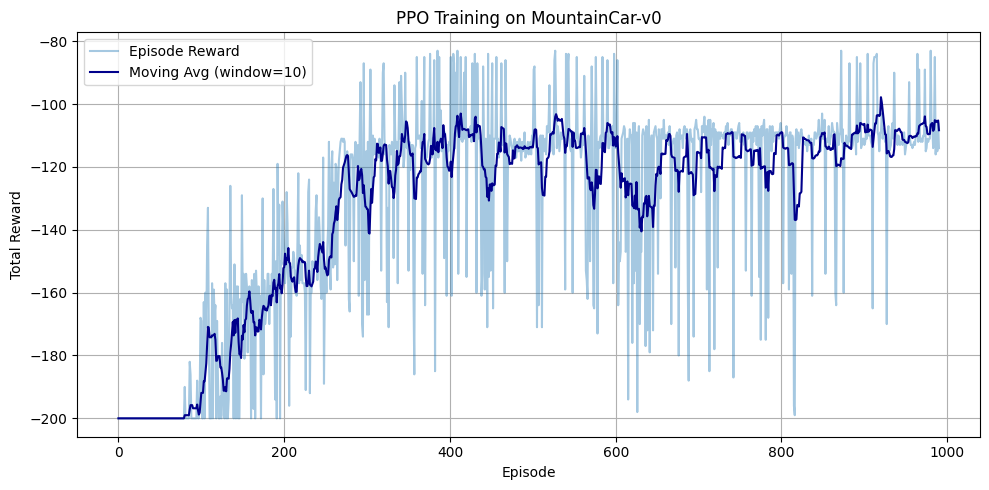

In [ ]:
#ppo
!pip install stable-baselines3[extra]

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import BaseCallback



SEED = 42
np.random.seed(SEED)



class RewardCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_rewards = []

    def _on_step(self) -> bool:
        if self.locals.get("dones") is not None:
            for done, info in zip(self.locals["dones"], self.locals["infos"]):
                if done and "episode" in info:
                    self.episode_rewards.append(info["episode"]["r"])
        return True


env = gym.make("MountainCar-v0")
env.reset(seed=SEED)
env.action_space.seed(SEED)
env = Monitor(env)


vec_env = DummyVecEnv([lambda: env])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=False, clip_obs=10.0)

callback = RewardCallback()



model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=0,
    seed=SEED,
    learning_rate=5e-4,
    n_steps=2048,
    batch_size=64,
    gae_lambda=0.9,
    gamma=0.99,
    n_epochs=20,
    clip_range=0.2,

)


model.learn(total_timesteps=130_000, callback=callback)


rewards = callback.episode_rewards
window_size = 10
moving_avg = [np.mean(rewards[max(0, i - window_size + 1):i + 1]) for i in range(len(rewards))]

plt.figure(figsize=(10, 5))
plt.plot(rewards, label="Episode Reward", alpha=0.4)
plt.plot(moving_avg, label=f"Moving Avg (window={window_size})", color='darkblue')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("PPO Training on MountainCar-v0")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("ppo_mountaincar_rewards.png")
plt.show()

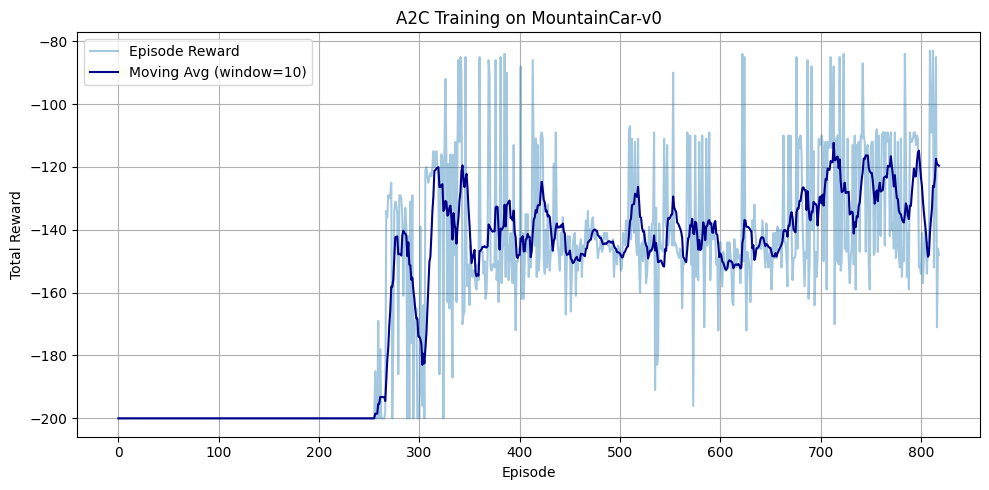

In [ ]:
#a2c
# pip install stable-baselines3[extra]
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

SEED = 42
np.random.seed(SEED)


class RewardCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_rewards = []

    def _on_step(self) -> bool:
        if self.locals.get("dones") is not None:
            for done, info in zip(self.locals["dones"], self.locals["infos"]):
                if done and "episode" in info:
                    self.episode_rewards.append(info["episode"]["r"])
        return True

def make_env():
    env = gym.make("MountainCar-v0")
    env.reset(seed=SEED)
    env.action_space.seed(SEED)
    env = Monitor(env)
    return env

vec_env = DummyVecEnv([make_env])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=False, clip_obs=10.0)


model = A2C(
    "MlpPolicy",
    vec_env,
    learning_rate=1e-3,
    gamma=0.99, #R_t = sum γ^k * r_{t+k}
    n_steps=5,
    gae_lambda=0.95,
    verbose=0,
    seed=SEED,
)

callback = RewardCallback()


model.learn(total_timesteps=130_000, callback=callback)

rewards = callback.episode_rewards
window_size = 10
moving_avg = [np.mean(rewards[max(0, i - window_size + 1):i + 1]) for i in range(len(rewards))]

plt.figure(figsize=(10, 5))
plt.plot(rewards, label="Episode Reward", alpha=0.4)
plt.plot(moving_avg, label=f"Moving Avg (window={window_size})", color='darkblue')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("A2C Training on MountainCar-v0")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("a2c_mountaincar_rewards.png")
plt.show()
